# Task 2. Segmenation

In this task, you will implement a segmentation algorithm. 

The dataset for this task is the Oxford Pets dataset (https://www.robots.ox.ac.uk/~vgg/data/pets/). The dataset contains images of cats and dogs, along with their corresponding segmentation masks.
We simplify the masks to binary masks, where the foreground is the animal and the background is everything else; we ignore the border class. 
The dataset is split into a training set and a test set. The training set contains ~ 3,700 images, while the test set contains 3,000 images.

Use U-Net to perform binary semantic segmentation.
1. (**0.5p -- 2p**) Implement U-Net (https://arxiv.org/abs/1505.04597) using PyTorch. You may use padded convolutions to avoid losing border pixels. Consider adding batch normalization.
2. (**1p**) Use Binary Cross Entropy to train the model and visualize predictions. Ignore the border class during loss computation.
3. (**1p**) Implement and calculate pixel accuracy, IoU and Dice coefficient.
4. (**1p**) Try different ways to deal with varied input sizes (resize, crop to smaller size, add padding). Then, pick a few images from the test set and perform inference on them while keeping their original size. Compare the results.
5. (**0.5p**) Perform an ablation study on residual connections in the U-Net architecture.



## Constatns

In [ ]:
IMG_SIZE = (128, 128)
TRANSFORM_METHOD = "resize"
# TRANSFORM_METHOD = "random_crop"
# TRANSFORM_METHOD = "center_crop"

UNET_MODEL = "undefined"

BATCH_SIZE = 64


## Setup

### Installation

In [2]:
!pip install segmentation_models_pytorch -q
!pip install wandb -qU

### Libraries

In [3]:
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import wandb
import os, sys, logging

from typing import Optional

from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torchvision.datasets import wrap_dataset_for_transforms_v2, OxfordIIITPet
from torchvision.tv_tensors import Mask
from tqdm.auto import tqdm
import torchvision.transforms.functional as F
import numpy as np

c:\Users\patry\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
wandb.login();

os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_CONSOLE"] = "off"

# logger = logging.getLogger("wandb")
# logger.setLevel(logging.ERROR)

# loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
# for logger in loggers:
# 	logger.setLevel(logging.WARN)

wandb: Currently logged in as: fejowo5522 (fejowo5522-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Data Loading

In [5]:
class SegmentationDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset, transform, length=None):
        self.dataset = dataset
        self.length = len(dataset)
        self.transform = transform

    def __getitem__(self, index):
        image, mask = self.dataset[index]
        return self.transform(image, mask)

    def __len__(self):
        return self.length
    
def create_wrapped_dataset(dataset, transform):
    wrapped_dataset = wrap_dataset_for_transforms_v2(dataset)
    return SegmentationDatasetWrapper(wrapped_dataset, transform=transform)


In [6]:
TRANSFORM_METHODS = {
    "none": v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    "resize": v2.Resize(size=IMG_SIZE, antialias=True),
    "random_crop": v2.Compose([
        v2.Resize(size=IMG_SIZE[0], antialias=True),
        v2.RandomCrop(size=IMG_SIZE)
    ]),
    "center_crop": v2.Compose([
        v2.Resize(size=IMG_SIZE[0], antialias=True),
        v2.CenterCrop(size=IMG_SIZE)
    ]),
    "pad": v2.Compose([
        v2.Resize(IMG_SIZE[0], antialias=True),
        v2.Pad(IMG_SIZE, fill=0)  # Custom padding logic if needed
    ])
}

transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
target_transform = lambda mask: Mask(2 - mask.squeeze(0))
train_ds_orig = OxfordIIITPet(root=".", target_types="segmentation", download=True, transform=transform, target_transform=target_transform)
test_ds_orig = OxfordIIITPet(root=".", split="test", target_types="segmentation", download=True, transform=transform, target_transform=target_transform)

def load_data(method=None):
    if method is None:
        method = TRANSFORM_METHOD

    transform_method_function = TRANSFORM_METHODS[method]

    train_ds = create_wrapped_dataset(train_ds_orig, transform=transform_method_function)
    test_ds = create_wrapped_dataset(test_ds_orig, transform=transform_method_function)

    return train_ds, test_ds

In [22]:
train_ds, test_ds = load_data()

### Plot original image and mask

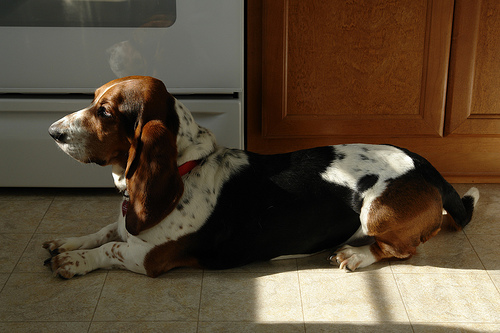

In [8]:
# Plot sample image
image_orig, mask_orig = train_ds_orig[2025]
image_orig

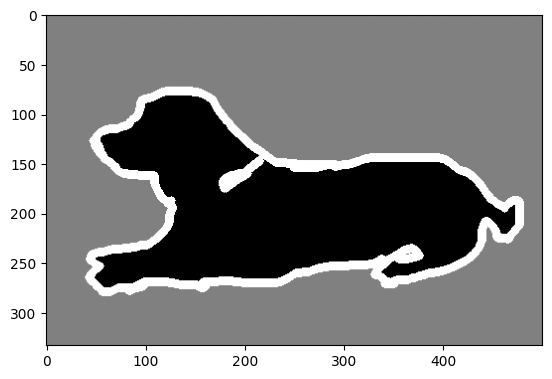

In [9]:
mask_np = np.array(mask_orig)
plt.imshow(mask_np, cmap="gray")
plt.show()

### Plot resized image and mask

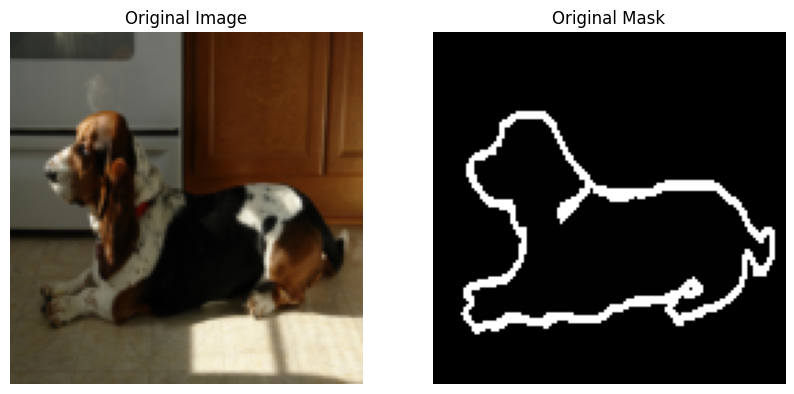

In [10]:
image, mask = train_ds[2025]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(mask.squeeze(0), cmap="gray")
plt.title("Original Mask")
plt.axis("off")
plt.show()

### Masks

Observe, that we modify the masks (1: foreground, 2: background, 3: border) to be (0: background, 1: foreground, 255: border).

Later we will ignore the border class during loss computation. 

In [11]:
mask.unique()  # tensor([0, 1], dtype=torch.uint8)

tensor([  0,   1, 255], dtype=torch.uint8)

## Evaluation metrics

In [12]:
# TASK 1.3:
def iou(gt, pred, ignore_index=255, eps=1e-8):
    # ignore index
    pred[gt == ignore_index] = 0
    gt[gt == ignore_index] = 0

    intersection = (gt & pred).sum(dim=1).float() # intersection is the number of pixels that are 1 in both gt and pred
    union = (gt | pred).sum(dim=1).float() # union is the number of pixels that are 1 in either gt or pred
    iou = intersection / (union + eps) # IoU (with small epsilon)

    return iou

def dice(gt, pred, ignore_index=255, eps=1e-8):
    # ignore index
    pred[gt == ignore_index] = 0
    gt[gt == ignore_index] = 0

    intersection = (gt & pred).sum(dim=1).float()
    cardinality = gt.sum(dim=1).float() + pred.sum(dim=1).float() # sum of cardinalities (number of pixels that are 1)
    dice = 2 * intersection / (cardinality + eps) # dice = 2 * |A * B| / (|A| + |B|)

    return dice

def accuracy(gt, pred, ignore_index=255):
    # ignore index
    pred[gt == ignore_index] = -1
    gt[gt == ignore_index] = -2

    correct = (gt == pred).sum(dim=1).float() # correct is the number of pixels that are equal in gt and pred (excluding ignore_index)
    total = gt.numel()// gt.shape[0] # total is the number of pixels in gt
    acc = correct / total

    return acc

def eval(model, dataloader):
    model.eval()

    metrics = {
        "loss": 0,
        "iou": 0,
        "dice": 0,
        "accuracy": 0,
    }

    ds_len = 0

    for batch in dataloader:
        images, masks = batch
        images = images.cuda()
        masks = masks.cuda()

        ds_len += images.shape[0]
        with torch.no_grad():
            loss, logits = model(images, masks)
            labels = torch.flatten(torch.sigmoid(logits) > 0.5, 1)
            gt = torch.flatten(masks, 1)

            metrics["loss"] += loss.sum().item()
            metrics["iou"] += iou(gt, labels).sum().item()
            metrics["dice"] += dice(gt, labels).sum().item()
            metrics["accuracy"] += accuracy(gt, labels).sum().item()

    for metric in metrics:
        metrics[metric] /= ds_len

    return metrics

## Model

### Segmentation models pytorch package UNet

In [ ]:
# TASK 1:
# Implement a UNet model
# (2p) implement a UNet model in pure pytorch
# (0.5p) implement a UNet model using segmentation_models_pytorch package
#        (see https://github.com/qubvel-org/segmentation_models.pytorch?tab=readme-ov-file#1-create-your-first-segmentation-model-with-smp), 
#        remember to use encoder_weights=None 
# Hint:
# - 'resnet18' as the encoder backbone could be a good choice for faster training
# - 'resnet34' as the encoder backbone could be a good choice for better accuracy

UNET_MODEL = "smp"

class UNet(nn.Module):
    def __init__(self, ignore_index=255):
        super(UNet, self).__init__()
        
        self.unet = smp.Unet(
            encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=None,          # no pre-trained weights
            in_channels=3,                 # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=1,                     # model output channels (number of classes in your dataset)
        )
        
        self.ignore_index = ignore_index

    def forward(
        self,
        pixel_values: torch.FloatTensor,
        labels: Optional[torch.LongTensor] = None,
    ):
        logits = self.unet(pixel_values)

        loss = None
        logits = logits.squeeze(1)  # adjust the shape of logits to match the target size
        if labels is not None:
            loss_fn = BCEWithLogitsLoss(reduction="none")
            loss = loss_fn(logits, labels.float())
            loss = loss[labels != self.ignore_index].mean()
        return loss, logits

### Custom UNet

In [ ]:
# TASK 1:
# Implement a UNet model
# (2p) implement a UNet model in pure pytorch

UNET_MODEL = "custom"


class DoubleConv(nn.Module):
    """
    (convolution => [BN] => ReLU) * 2
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
          
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """
    Downscaling with maxpool -> double conv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """
    Upscaling then double conv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        # x1 is the output of the previous layer
        # x2 is the corresponding encoder layer

        x1 = self.up(x1)

        # input is CHW, ensure that x1 is the same size as x2
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # concatenate along the channels axis
        x = torch.cat([x2, x1], dim=1)

        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, ignore_index=255):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)

        factor = 2
        
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

        self.ignore_index = ignore_index

    def forward(
        self,
        pixel_values: torch.FloatTensor,
        labels: Optional[torch.LongTensor] = None,
    ):
        # encode
        x1 = self.inc(pixel_values)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # decode
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)

        loss = None
        if labels is not None:
            # BCEWithLogitsLoss per-pixel, ignoring specified index
            criterion = nn.BCEWithLogitsLoss(reduction='none')

            # calc raw loss
            labels_float = labels.float()
            raw_loss = criterion(logits, labels_float)
            
            # calc loss ingoring ignore_index
            mask = (labels != self.ignore_index).unsqueeze(1).float()
            loss = raw_loss * mask
        
            # normalize by number of valid pixels
            loss = loss.sum() / mask.sum().clamp(min=1)

        return loss, logits


### Create dataloaders

One can experiment with different batch sizes.

In [15]:
train_dataloder = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloder = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Training

Below is the training loop and some partial results from W&B tracking.
The project is not shared.

In [ ]:
TEST_MODE = "any"

### Training function

In [17]:
def train():
    global IMG_SIZE, BATCH_SIZE, TRANSFORM_METHOD, UNET_MODEL, TEST_MODE
    global train_dataloder, test_dataloder

    ignore_index = 255

    config = {
        "learning_rate": 1e-4,
        "epochs": 3,
        "img_size": IMG_SIZE,
        "batch_size": BATCH_SIZE,
        "model": "UNet " + UNET_MODEL,
        "encoder": "resnet18",
        "encoder_weights": None,
        "transform_method": TRANSFORM_METHOD,
        "test": TEST_MODE,
    }

    run = wandb.init(
        project="List4",
        config=config,
    )

    unet = UNet(ignore_index=ignore_index).cuda()
    optimizer = torch.optim.Adam(unet.parameters(), lr=config["learning_rate"])

    for epoch_idx in tqdm(range(config["epochs"]), desc="epoch"):
        unet.train()
        for batch in tqdm(train_dataloder, desc="batch"):
            optimizer.zero_grad()

            images, masks = batch
            images = images.cuda()
            masks = masks.cuda()

            loss, logits = unet(images.cuda(), masks.cuda())
            
            loss = loss.mean()
            loss.backward()
            optimizer.step()

            labels = torch.flatten(torch.sigmoid(logits) > 0.5, 1)
            gt = torch.flatten(masks, 1)

            run.log({
                "epoch": epoch_idx,
                "train/loss": loss.item(),
                "train/iou": iou(gt, labels).mean(),
                "train/dice": dice(gt, labels).mean(),
                "train/accuracy": accuracy(gt, labels).mean(),
                })

        metrics = eval(unet, test_dataloder)
        for metric, value in metrics.items():
            run.log({f"eval/{metric}": value})
            
    run.finish()

    return unet

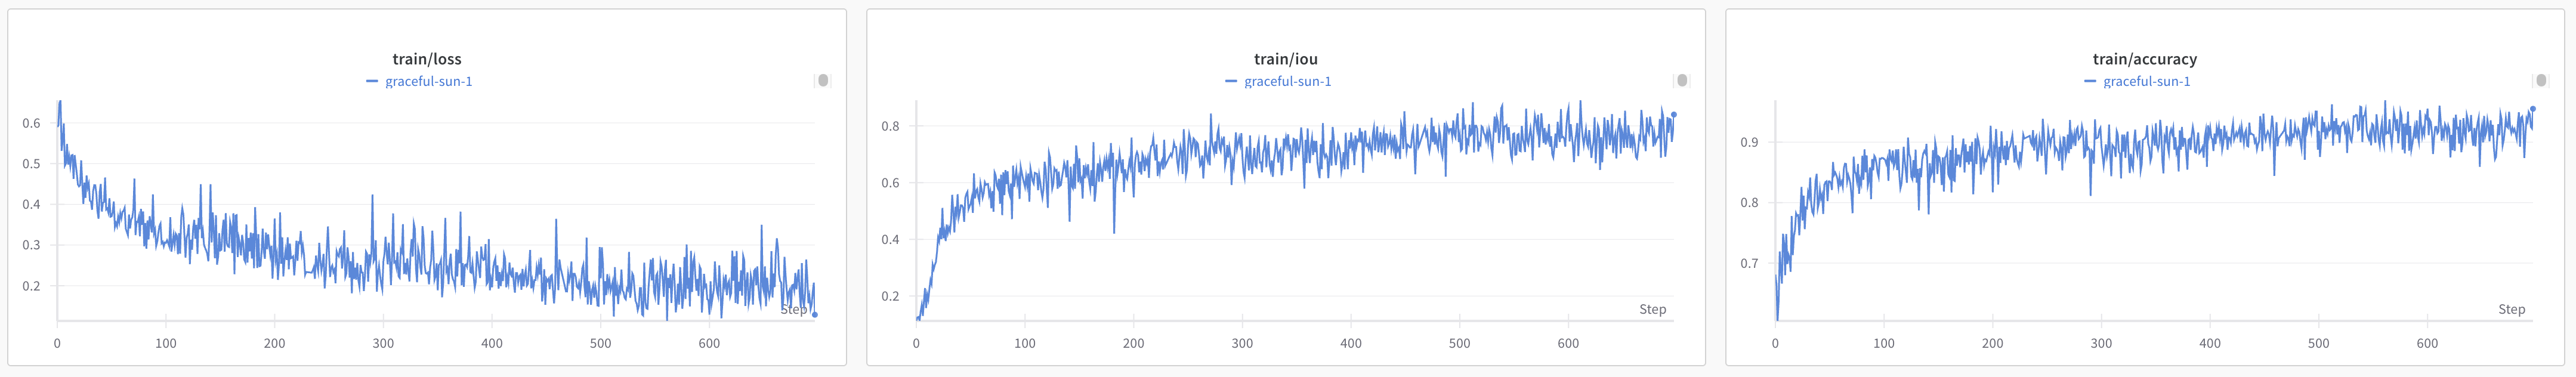

In [23]:
if TEST_MODE == "simple_train" or TEST_MODE == "any":
    train_ds, test_ds = load_data()
    train_dataloder = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloder = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    unet = train()
    

epoch:   0%|          | 0/3 [00:00<?, ?it/s]


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

### Compare batch sizes

In [ ]:
TEST_MODE = "compare_batch"

for BATCH_SIZE in tqdm([8, 16, 32, 64, 128, 254, 512], desc="batch size"):
    train_dataloder = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloder = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    train()

NameError: name 'TEST_MODE' is not defined

### Compare transform methods

In [ ]:
TEST_MODE = "compare_transforms"

# for method_name, transform in TRANSFORM_METHODS.items():
#     if method_name == "none":
#         continue

#     print(f"Transform: {method_name}")
#     train_ds, test_ds = load_data(method_name)

#     train_dataloder = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
#     test_dataloder = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

#     unet = train()

#     metrics = eval(unet, test_ds)
#     for metric, value in metrics.items():
#         print(f"{metric}: {value:.4f}")
#     print("\n")

# train_ds, test_ds = load_data()

train_ds, test_ds = load_data(method="none")

train_dataloder = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloder = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

unet = train()

metrics = eval(unet, test_ds)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")
print("\n")

Transform: resize


epoch:   0%|          | 0/3 [00:00<?, ?it/s]


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

### Test trained model on non-resized images

In [ ]:
TEST_MODE == "show_no_transform"

train_ds, test_ds = load_data(method="none")

train_dataloder = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloder = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

unet = train()

In [ ]:
train_ds, test_ds = load_data("none")

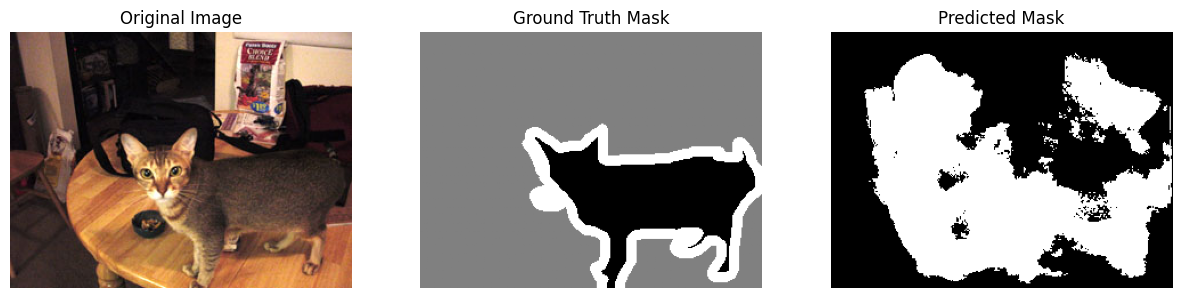

In [ ]:
sample_image, sample_mask = next(iter(test_ds))

sample_image = sample_image.cuda()
sample_mask = sample_mask.cuda()


unet.eval()
with torch.no_grad():
    _, logits = unet(sample_image.unsqueeze(0))

predicted_mask = (torch.sigmoid(logits) > 0.5).squeeze(1).cpu()

# plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(sample_image.cpu().permute(1, 2, 0))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sample_mask[0].cpu().squeeze(0), cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask[0], cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()